# Second order updates on the $\alpha_{\epsilon}(A)$ level set
This script serves to measure the effectiveness of different retractions on the smoothed spectral abscissa level set

In [235]:
import numpy as np
from scipy.linalg import solve_continuous_lyapunov
import matplotlib.pyplot as plt
from tqdm import tqdm
from ssa import ssa, optimize_ssa, ssa_newton_retraction

In [236]:
def lyap_differential(X: np.array, Y: np.array, V: np.array):
    Q = V @ Y + Y @ V.T
    return solve_continuous_lyapunov(X, -Q)

def random_tangent(g: np.array):

    # flatten and remember original shape
    orig_shape = g.shape    
    g = np.ravel(g)

    # generate random ambient vector
    v = np.random.random(size=(g.size,))

    # remove the component in the direction of g
    g_comp = np.dot(v, g) / np.dot(g, g)
    v = v - (g_comp * g)

    # rescale
    v = v / np.linalg.norm(v)

    # reshape
    v = np.reshape(v, orig_shape)

    return v

def hvp(A: np.array, V: np.array, s: float, Q: np.array, P: np.array):

    n = A.shape[0]

    # NOTE: Maybe we drop the s part here...
    # DVP = lyap_differential(A - s * np.identity(n), P, V)
    # DVQ = lyap_differential(A.T - s * np.identity(n), Q, V)
    DVP = lyap_differential(A, P, V)
    DVQ = lyap_differential(A.T, Q, V) # NOTE: This is the most shaky part...

    # if np.linalg.norm(np.ravel(DVP - DVQ.T)) < 0.1:
    #     print("interestingment")

    DVQP = DVQ @ P + Q @ DVP

    QP = Q@P
    TrQP = np.trace(QP)
    TrDVQP = np.trace(DVQP)

    DV_ssa = ((DVQP * TrQP) - (QP * TrDVQP)) / (TrQP**2)

    return DV_ssa

def compute_corrections(A: np.array, V: np.array, s: float, G: np.array, Q: np.array, P: np.array):

    # compute Hessian-Vector products
    H_1 = hvp(A, G, s, Q, P)
    H_2 = hvp(A, V, s, Q, P)

    h_1 = np.ravel(H_1)
    h_2 = np.ravel(H_2)
    g = np.ravel(G)
    v = np.ravel(V)

    # compute coefficients of the quadratic
    a = np.dot(g, h_1)
    b = 2 * (np.dot(g, g) + np.dot(g, h_1))
    c = np.dot(v, h_2)

    alpha_1 = -c / (2 * np.dot(g, g)) # no need for h_1
    # NOTE: should maybe be using the stable version of the quadratic formula
    # alpha_2_1 = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a) # quadratic solution +
    # alpha_2_2 = (-b - np.sqrt(b**2 - 4 * a * c)) / (2 * a) # quadratic solutoin -

    alpha_2_1 = (2 * c) / (-b - np.sqrt(b**2 - 4 * a * c))
    # alpha_2_2 = (2 * c) / (-b + np.sqrt(b**2 - 4 * a * c))
    alpha_2_2 = -c / b


    return alpha_1, alpha_2_1, alpha_2_2

In [239]:
# test the HVP alignment
thetas = []

# for each matrix A
for A in As:    
    for i in range(5):
        ## find the current ssa and gradient
        s, G, Q, P = ssa(A, eps, ret_QP=True)

        ## pick a direction tangent to the surface
        V = random_tangent(G) * 0.1

        ## step
        A_ = A + V    

        ## calculate new differential = 2 PQ / Tr(PQ)
        s_, G_, Q_, P_ = ssa(A_, eps, ret_QP=True)

        ## calculate HVP at original in the direction V
        H = hvp(A, V, s, Q, P)

        ## See if the difference between the differentials aligns with V
        D = G_ - G

        vec_D = np.ravel(D)
        vec_H = np.ravel(H)

        theta = np.arccos(np.dot(vec_D, vec_H) / (np.linalg.norm(vec_D) * np.linalg.norm(vec_H)))

        theta = theta * 180 / np.pi

        thetas.append(theta)

(array([ 2.,  2., 12., 30., 50., 57., 62., 46., 53., 47., 29., 34., 20.,
        16., 10.,  6.,  7.,  6.,  4.,  1.,  3.,  0.,  1.,  0.,  2.]),
 array([ 6.22991314,  8.29980061, 10.36968809, 12.43957557, 14.50946304,
        16.57935052, 18.649238  , 20.71912548, 22.78901295, 24.85890043,
        26.92878791, 28.99867538, 31.06856286, 33.13845034, 35.20833782,
        37.27822529, 39.34811277, 41.41800025, 43.48788772, 45.5577752 ,
        47.62766268, 49.69755016, 51.76743763, 53.83732511, 55.90721259,
        57.97710006]),
 <BarContainer object of 25 artists>)

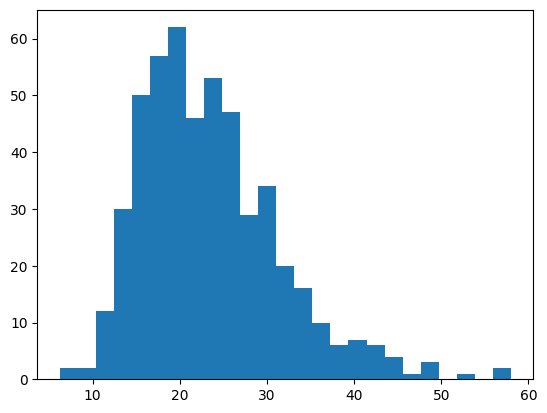

In [240]:
# NOTE: This needs to be fixed otherwise we can't really be confident
plt.hist(thetas, bins=25)

In [200]:
N = 32
n_matrices = 100
eps = 0.02
target = -0.1

In [201]:
# generate a lot of stability optimized matrices
As = [optimize_ssa(np.random.normal(0.0, 1.0, size=(N, N)), eps, target, step_size=1.0, iters=40)[0] for i in tqdm(range(n_matrices))]

100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


In [202]:
ssas = [ssa(A, eps, grad=False) for A in As]
sas = [np.max(np.real(np.linalg.eigvals(A))) for A in As]

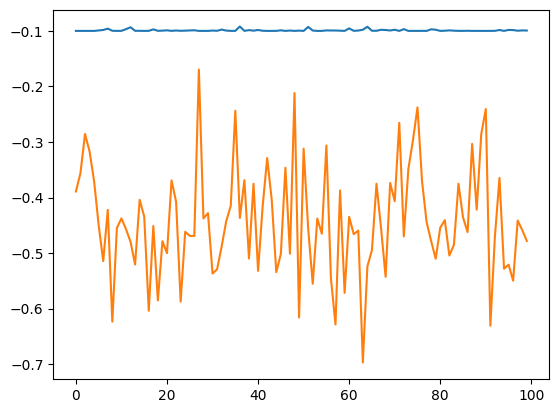

In [203]:
plt.plot(ssas)
plt.plot(sas)

(array([45.,  8.,  6.,  5.,  7.,  4.,  3.,  0.,  1.,  1.,  5.,  0.,  1.,
         3.,  1.,  0.,  0.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.1       , -0.09984094, -0.09968188, -0.09952282, -0.09936376,
        -0.0992047 , -0.09904564, -0.09888658, -0.09872752, -0.09856846,
        -0.0984094 , -0.09825034, -0.09809127, -0.09793221, -0.09777315,
        -0.09761409, -0.09745503, -0.09729597, -0.09713691, -0.09697785,
        -0.09681879, -0.09665973, -0.09650067, -0.09634161, -0.09618255,
        -0.09602349, -0.09586443, -0.09570537, -0.09554631, -0.09538725,
        -0.09522819, -0.09506913, -0.09491007, -0.09475101, -0.09459195,
        -0.09443288, -0.09427382, -0.09411476, -0.0939557 , -0.09379664,
        -0.09363758, -0.09347852, -0.09331946, -0.0931604 , -0.09300134,
        -0.09284228, -0.09268322, -0.09252416, -0.0923651 ,

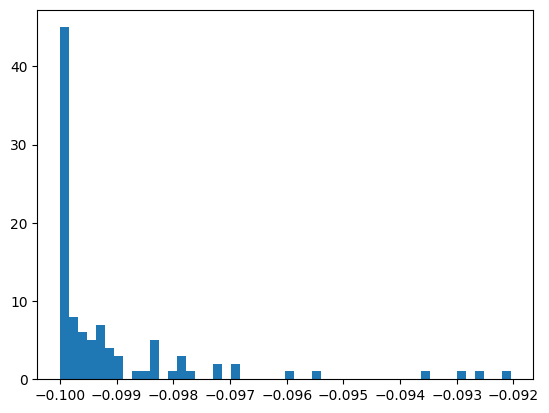

In [204]:
# check that their spectral abscissa are below 0
plt.hist(np.array(ssas), bins=50)

In [215]:
step_size = 1.0

In [216]:
s_dels = [] # step
sp_dels = [] # step, project
sfc_dels = [] # step, FO correct
sfcp_dels = [] # step, FO correct, project
ssc_1_dels = [] # step, SO correct
ssc_1p_dels = [] # step, SO correct, project
ssc_2_dels = [] # step, SO correct
ssc_2p_dels = [] # step, SO correct, project

fo_cs = []
so_c_1s = []
so_c_2s = []

# for each array
for A in As:    

    ## find the current ssa and gradient
    s, G, Q, P = ssa(A, eps, ret_QP=True)
    
    ## pick a direction tangent to the surface
    V = random_tangent(G) * step_size

    ## step
    A_s = A + V

    ## step, project
    A_sp = ssa_newton_retraction(A, V, eps, target)

    fo_c, so_c_1, so_c_2 = compute_corrections(A, V, s, G, Q, P)
    fo_cs.append(fo_c)
    so_c_1s.append(so_c_1)
    so_c_2s.append(so_c_2)

    ## step, FO correct
    A_sfc = A_s + (fo_c * G)
    ## step, FO correct, project
    A_sfcp = ssa_newton_retraction(A, V + (fo_c * G), eps, target)
    
    ## step, SO correct
    A_ssc_1 = A_s + (so_c_1 * G)
    A_ssc_2 = A_s + (so_c_2 * G)
    ## step, SO correct, project
    A_ssc_1p = ssa_newton_retraction(A, V + (so_c_1 * G), eps, target)
    A_ssc_2p = ssa_newton_retraction(A, V + (so_c_2 * G), eps, target)
    
    # find difference from the original s:
    s_dels.append(ssa(A_s, eps, grad=False, ret_QP=False) - s)
    sp_dels.append(ssa(A_sp, eps, grad=False, ret_QP=False) - s)
    sfc_dels.append(ssa(A_sfc, eps, grad=False, ret_QP=False) - s)
    sfcp_dels.append(ssa(A_sfcp, eps, grad=False, ret_QP=False) - s)
    ssc_1_dels.append(ssa(A_ssc_1, eps, grad=False, ret_QP=False) - s)
    ssc_1p_dels.append(ssa(A_ssc_1p, eps, grad=False, ret_QP=False) - s)
    ssc_2_dels.append(ssa(A_ssc_2, eps, grad=False, ret_QP=False) - s)
    ssc_2p_dels.append(ssa(A_ssc_2p, eps, grad=False, ret_QP=False) - s)


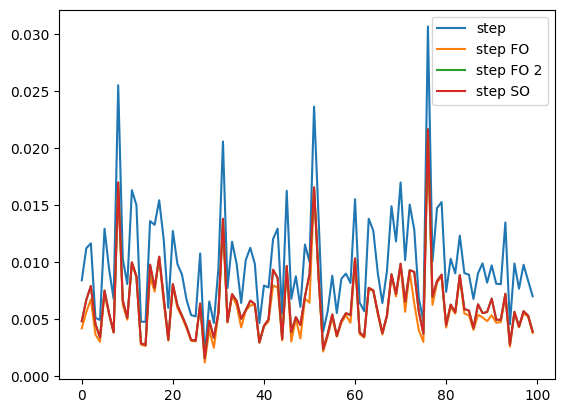

In [217]:
plt.plot(np.abs(s_dels), label="step")
# plt.plot(np.abs(sp_dels))
plt.plot(np.abs(sfc_dels), label="step FO")
# plt.plot(np.abs(sfcp_dels))
plt.plot(np.abs(ssc_2_dels), label="step FO 2")
# plt.plot(np.abs(sfcp_dels))
plt.plot(np.abs(ssc_1_dels), label="step SO")
# plt.plot(np.abs(ssc_1p_dels))
plt.legend()
plt.show()

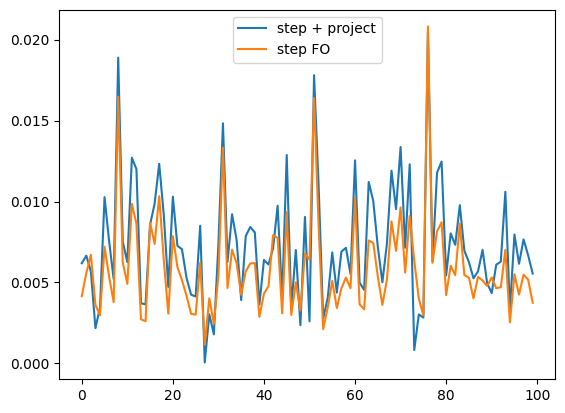

In [218]:
plt.plot(np.abs(sp_dels), label="step + project")
# plt.plot(np.abs(sfcp_dels), label="step FO + project")
plt.plot(np.abs(sfc_dels), label="step FO")
# plt.plot(np.abs(ssc_1p_dels), label="step SO + project")
plt.legend()
# plt.ylim(-0.1, 5.0)
plt.show()

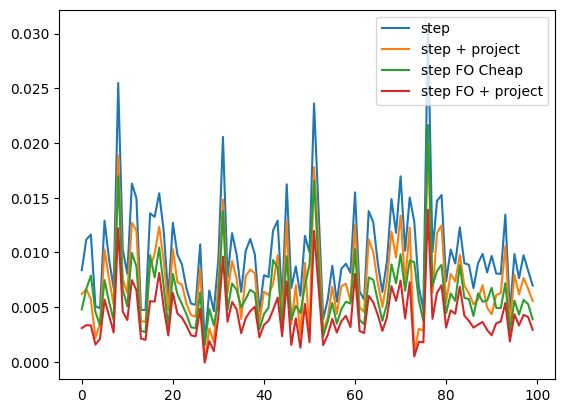

In [219]:
plt.plot(s_dels, label="step")
plt.plot(sp_dels, label="step + project")
# plt.plot(np.abs(sfcp_dels), label="step FO + project")
# plt.plot(sfc_dels, label="step FO")
plt.plot(ssc_2_dels, label="step FO Cheap")
plt.plot(sfcp_dels, label="step FO + project")
plt.legend()
# plt.ylim(-0.1, 5.0)
plt.show()

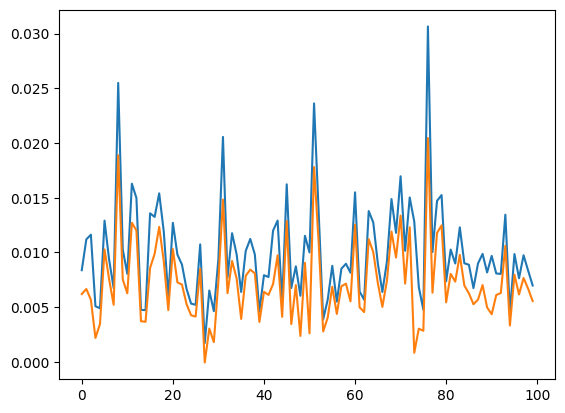

In [220]:
plt.plot(s_dels)
plt.plot(sp_dels)
plt.show()

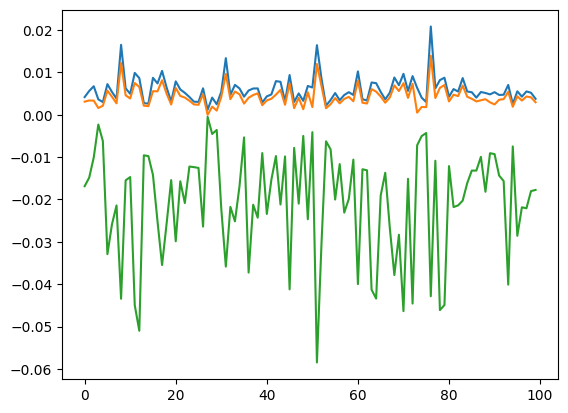

In [221]:
plt.plot(sfc_dels)
plt.plot(sfcp_dels)
plt.plot(fo_cs)
plt.show()

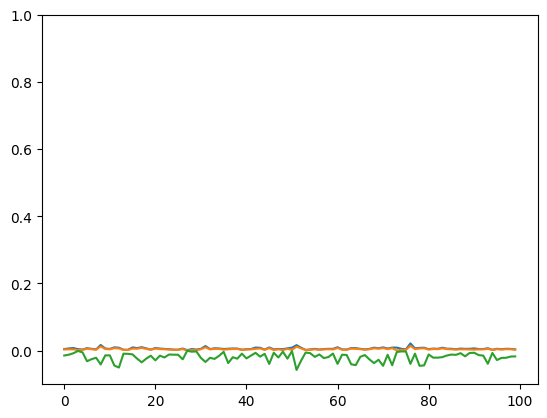

In [222]:
plt.plot(ssc_1_dels)
plt.plot(ssc_1p_dels)
plt.plot(so_c_1s)
plt.ylim(-0.1, 1.0)
plt.show()

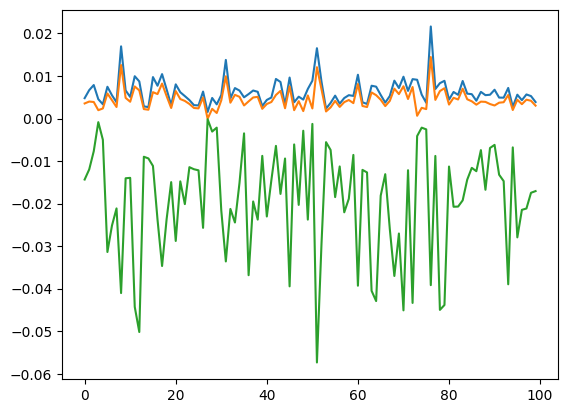

In [223]:
plt.plot(ssc_2_dels)
plt.plot(ssc_2p_dels)
plt.plot(so_c_2s)
plt.show()